# PUC Rio | MVP | Análise de Dados

Aluno: Joel Carneiro Dutra


## **Definição do Problema:**

Uma empresa que possui várias franquias de lojas, estava enfrentado problemas com o excesso de estoque em algumas franquias e a falta de produtos em outras, levando a desperdícios e perda de vendas. A empresa tinha dificuldade em ajustar o abastecimento de cada unidade com base nas necessidades de demanda específica de cada franquia.
Eles dependiam de métodos manuais e imprecisos para distribuir os suprimentos, o que resultava em altos custos operacionais e ineficiência.

## **Solução com análise de dados:**

### **Passo 1: Coleta dos Dados**

Foram coletados dados de vendas históricas entre franquias distintas, horários de maior movimento, sazonalidade, promoções anteriores e padrões de comportamento dos clientes.


Esta etapa foi realizada por meio de uma extração no Google BigQuery, contendo os seguintes campos no arquivo de extensão CSV:

- **dt_venda**      - Data em que a venda foi realizada
- **loja**          - Código das franquias que realizaram as vendas
- **uf**            - UF das franquias
- **produto**       - Descrição do produto vendido (Produto X, Y e Z)
- **canal_venda**   - Canal onde ocorreu a venda (Loja ou Site)
- **tipo_venda**    - Tipo de venda (Promoção ou Regular)
- **vlr_venda**     - Valor total da venda
- **qt_venda**      - Quantidade de itens vendidos

Atributos:
- **qt_dias_com_estoque** - Quantidade de dias em que a loja tinha estoque
- **qt_dias_sem_estoque** - Quantidade de dias em que a loja não tinha estoque
- **qt_dias_com_estoque_aberta** - Quantidade de dias em que a loja tinha estoque e estava aberta para venda
- **qt_dias_sem_estoque_aberta** - Quantidade de dias em que a loja não tinha estoque e estava aberta para venda
- **qt_dias_loja_fechada** - Quantidade de dias em que a loja esteve fechada
- **estoque_loja** - Quantidade de estoque da loja
- **habilitador** - Determina se a loja deverá ser abastecida caso tenha menos que 5 itens em seu estoque (variável 1 ou 0)

**Observação:** Por se tratar de dados da empresa onde trabalho, foi necessário alterar os nomes dos campos para proteção dos dados.

In [1]:
# Imports necessários

import requests
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import missingno as ms
import urllib.request
import seaborn as sns

In [2]:
# Definir a URL do arquivo CSV no GitHub
csv_url = "https://raw.githubusercontent.com/joel-c-dutra/mvp-ad/refs/heads/main/base_historica.csv"

caminho_arquivo = csv_url

# Leitura do arquivo CSV em um DataFrame
dataset = pd.read_csv(caminho_arquivo)
dataset.head()

,dt_venda,loja,uf,produto,canal_venda,tipo_venda,vlr_venda,qt_venda,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,estoque_loja,habilitador
0,2023-01-13,ABC13387,SP,Produto X,LOJA,PROMOCAO,122.0,0,2,26,2,4,22,0,1
1,2023-01-31,ABC12684,SP,Produto Z,LOJA,PROMOCAO,260.0,0,21,0,19,0,2,1,1
2,2023-01-14,ABC18631,MG,Produto X,LOJA,PROMOCAO,123.0,0,19,9,3,0,25,0,1
3,2023-01-06,ABC18630,MG,Produto Z,LOJA,PROMOCAO,210.0,0,22,6,3,0,25,7,0
4,2023-01-01,ABC12684,SP,Produto Z,LOJA,PROMOCAO,213.0,0,28,0,27,0,1,4,1


### **Passo 2: Análise dos Dados**

Nessa etapa os dados são disponibilizados para consulta e análise,
apresentado algumas informações do dataset, tais como:

- Volume de registros
- Tipo de dado de cada atributo
- Descrição dos campos
- Verificação por campos nulos
- Histograma
- Matriz de Correlação

In [3]:
# Mostra as informações do dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18599 entries, 0 to 18598
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   dt_venda                    18599 non-null  object
 1   loja                        18599 non-null  object
 2   uf                          18599 non-null  object
 3   produto                     18599 non-null  object
 4   canal_venda                 18599 non-null  object
 5   tipo_venda                  18599 non-null  object
 6   vlr_venda                   18599 non-null  object
 7   qt_venda                    18599 non-null  int64 
 8   qt_dias_com_estoque         18599 non-null  int64 
 9   qt_dias_sem_estoque         18599 non-null  int64 
 10  qt_dias_com_estoque_aberta  18599 non-null  int64 
 11  qt_dias_sem_estoque_aberta  18599 non-null  int64 
 12  qt_dias_loja_fechada        18599 non-null  int64 
 13  estoque_loja                18599 non-null  in

In [4]:
# Mostra as dimensões do dataset
print(dataset.shape)

(18599, 15)


In [5]:
# Faz um resumo estatístico do dataset (média, desvio padrão, mínimo, máximo e os quartis)
dataset.describe()

,qt_venda,qt_dias_com_estoque,qt_dias_sem_estoque,qt_dias_com_estoque_aberta,qt_dias_sem_estoque_aberta,qt_dias_loja_fechada,estoque_loja,habilitador
count,18599.000000,18599.000000,18599.000000,18599.000000,18599.000000,18599.000000,18599.000000,18599.000000
mean,0.498898,18.699930,3.341040,15.158234,1.839723,5.043013,26.741223,0.491478
std,2.117651,7.388197,6.574242,6.664947,4.374471,4.599696,65.168058,0.499941
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,15.000000,0.000000,12.000000,0.000000,3.000000,2.000000,0.000000
50%,0.000000,21.000000,0.000000,17.000000,0.000000,4.000000,6.000000,0.000000
75%,0.000000,22.000000,3.000000,19.000000,0.000000,5.000000,19.000000,1.000000
max,88.000000,30.000000,29.000000,28.000000,23.000000,28.000000,643.000000,1.000000


In [6]:
# verificando nulls no dataset
dataset.isnull().sum()

,0
dt_venda,0
loja,0
uf,0
produto,0
canal_venda,0
tipo_venda,0
vlr_venda,0
qt_venda,0
qt_dias_com_estoque,0
qt_dias_sem_estoque,0


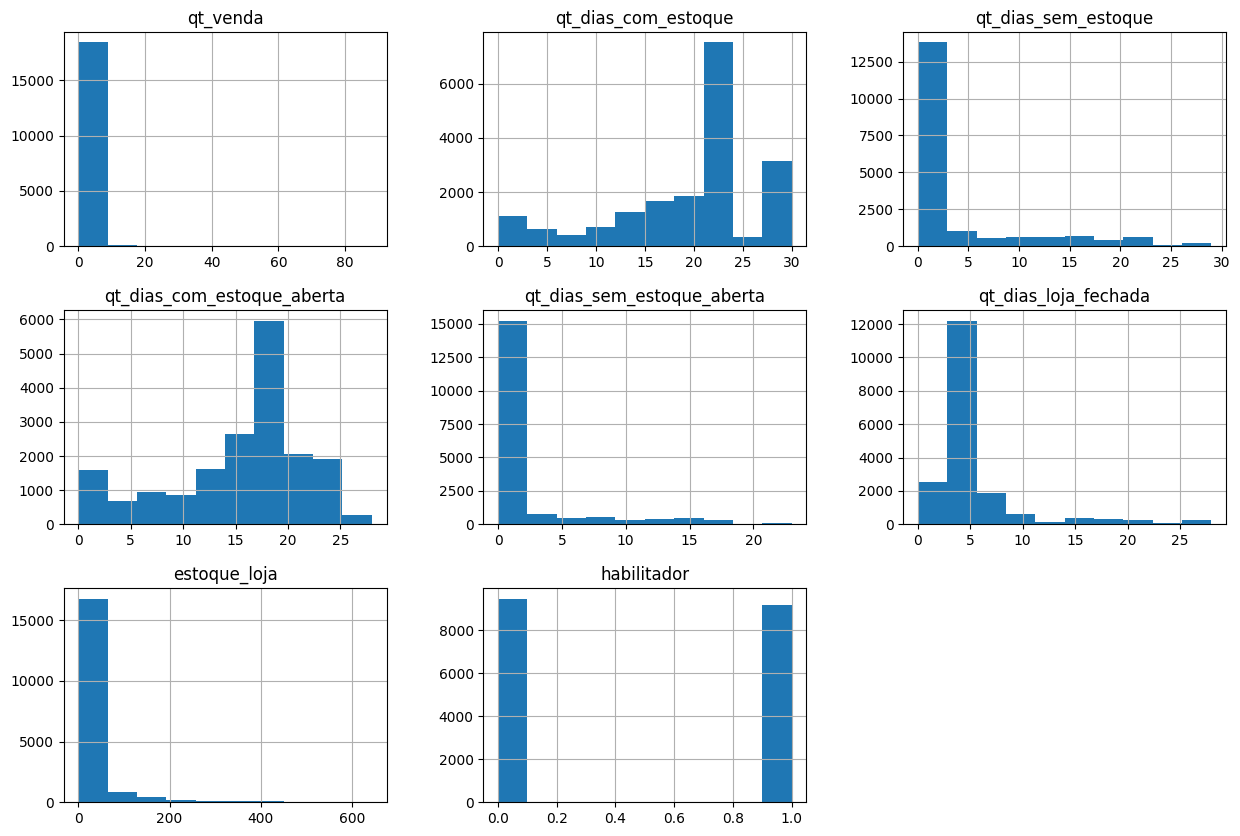

In [7]:
# Histograma
dataset.hist(figsize = (15,10))
plt.show()

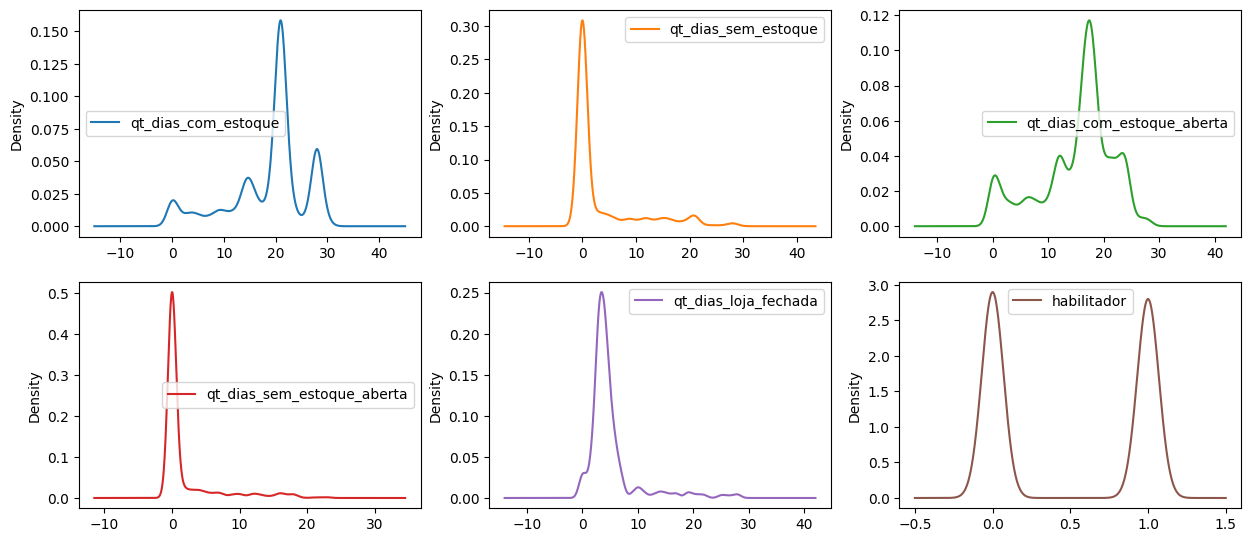

In [8]:
# Density Plot

dataset_atributos = dataset.loc[:, ['qt_dias_com_estoque', 'qt_dias_sem_estoque', 'qt_dias_com_estoque_aberta', 'qt_dias_sem_estoque_aberta', 'qt_dias_loja_fechada', 'habilitador']]

dataset_atributos.plot(kind = 'density', subplots = True, layout = (3,3), sharex = False, figsize = (15,10))
plt.show()

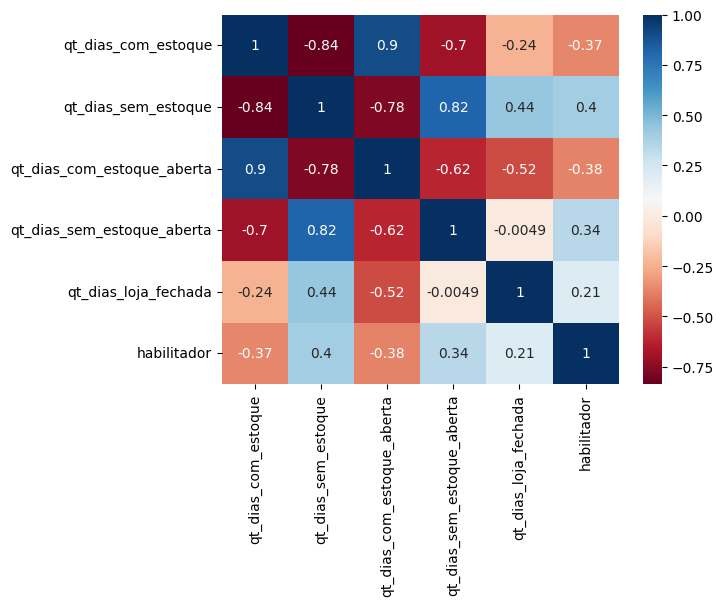

In [9]:
# Matriz de Correlação

dataset_atributos = dataset.loc[:, ['qt_dias_com_estoque', 'qt_dias_sem_estoque', 'qt_dias_com_estoque_aberta', 'qt_dias_sem_estoque_aberta', 'qt_dias_loja_fechada', 'habilitador']]

sns.heatmap(dataset_atributos.corr(), annot=True, cmap='RdBu');

### **Passo 3: Visualização dos Dados (Dataviz)**

Nessa etapa os dados são utilizados para retornar informações por meio de gráficos e seus resultados obtidos, apresentado algumas informações, tais como:

- Volume total de vendas
- Volume total de itens vendidos
- Histórico de vendas
- Vendas por UF
- Vendas por loja
- Vendas por produto

**Volume total de vendas**

O valor total de vendas é: 3397622.071 ou R$ 3.40M


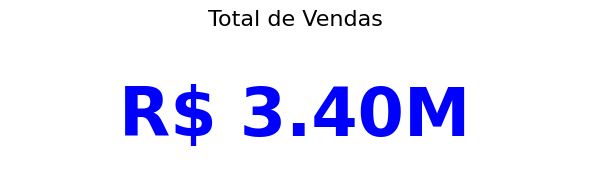

In [31]:
#Converte a coluna 'vlr_venda' para numérico
dataset['vlr_venda'] = pd.to_numeric(dataset['vlr_venda'], errors='coerce')

#Variável que recebe a soma do valor total
total_vendas = dataset['vlr_venda'].sum()

# Função para abreviar grandes números
def abreviar_numero(num):
    if abs(num) >= 1_000_000:  # Milhões
        return f'R$ {num/1_000_000:.2f}M'
    elif abs(num) >= 1_000:  # Milhares
        return f'R$ {num/1_000:.2f}K'
    else:  # Menos de mil
        return f'R$ {num:.2f}'

# Variável que recebe a soma do valor total (formatação abreviada)
valor_abreviado = abreviar_numero(total_vendas)

print(f"O valor total de vendas é: {total_vendas} ou {valor_abreviado}")


# Crie a figura
fig, ax = plt.subplots(figsize=(6, 2))

# Oculta os eixos
ax.axis('off')

# Exibe o número no centro da figura
ax.text(0.5, 0.5, valor_abreviado, fontsize=48, ha='center', va='center', fontweight='bold', color='b')

# Título opcional
plt.title('Total de Vendas', fontsize=16, pad=20)

# Exibe o gráfico
plt.tight_layout()
plt.show()

**Volume total de itens vendidos**

O volume total de vendas por item é: 9279


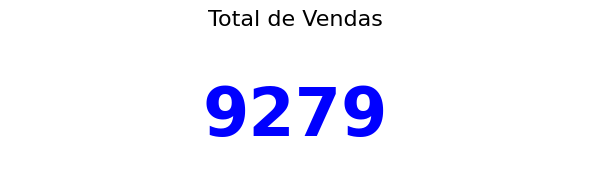

In [32]:
#Variável que recebe a soma do valor total
total_itens_vendidos = dataset['qt_venda'].sum()

print(f"O volume total de vendas por item é: {total_itens_vendidos}")


# Crie a figura
fig, ax = plt.subplots(figsize=(6, 2))

# Oculta os eixos
ax.axis('off')

# Exibe o número no centro da figura
ax.text(0.5, 0.5, total_itens_vendidos, fontsize=48, ha='center', va='center', fontweight='bold', color='b')

# Título opcional
plt.title('Total de Vendas', fontsize=16, pad=20)

# Exibe o gráfico
plt.tight_layout()
plt.show()

**Histórico de vendas por mês**

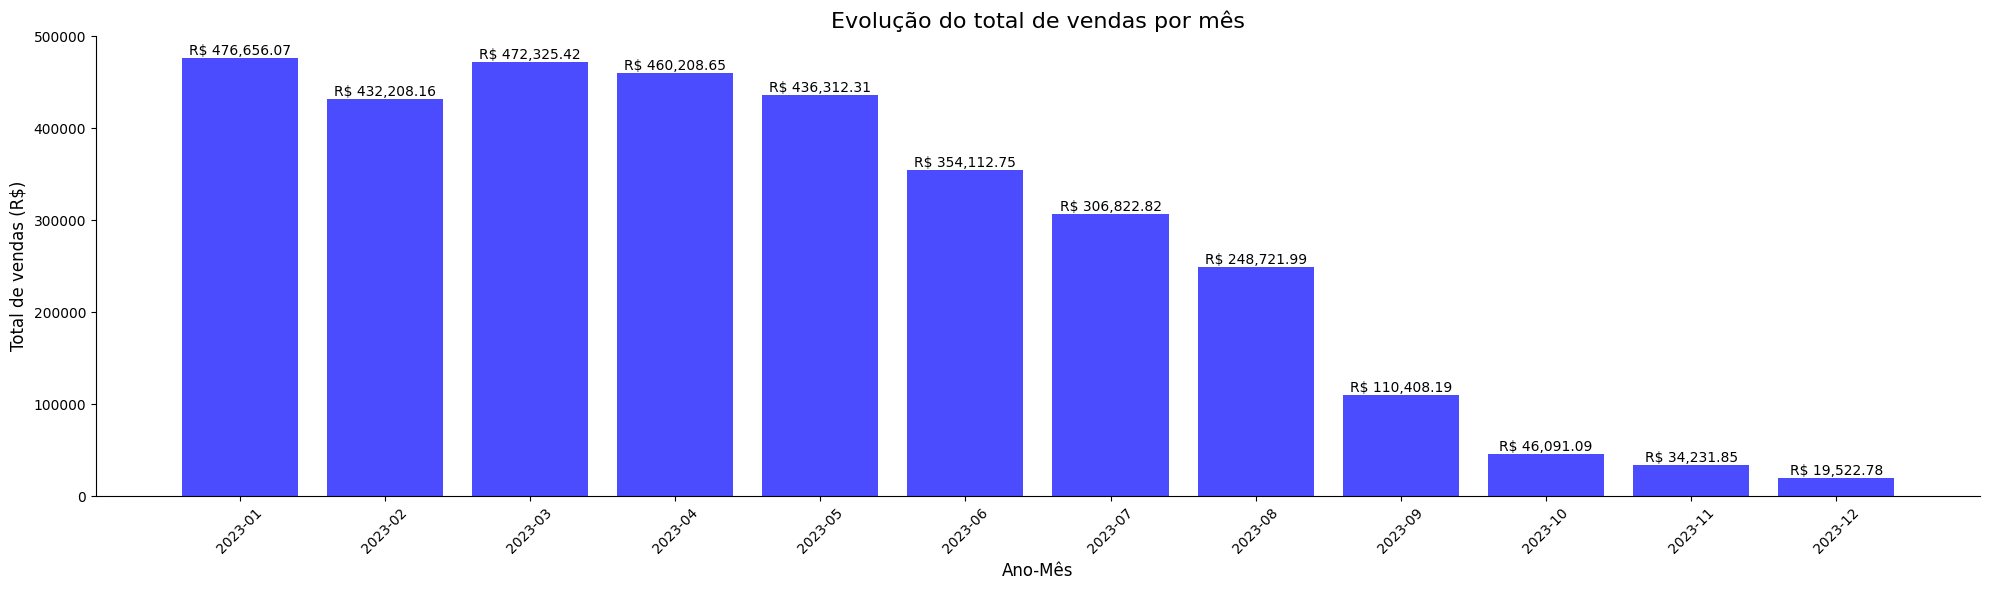

In [12]:
# Converte a coluna 'dt_venda' para o formato de data
dataset['dt_venda'] = pd.to_datetime(dataset['dt_venda'], errors='coerce')

# Cria uma coluna 'mes_ano' no formato MM-YYYY
dataset['mes_ano'] = dataset['dt_venda'].dt.to_period('M').astype(str)

# Agrupa as vendas por mês-ano e soma os valores
dataset_grouped = dataset.groupby('mes_ano', as_index=False)['vlr_venda'].sum()

# Plota o gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(dataset_grouped['mes_ano'], dataset_grouped['vlr_venda'], color='b', alpha=0.7)

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(dataset_grouped['vlr_venda']):
    plt.text(i, value, f'R$ {value:,.2f}', ha='center', va='bottom')

# Configurações do gráfico
plt.title('Evolução do total de vendas por mês', fontsize=16)
plt.xlabel('Ano-Mês', fontsize=12)
plt.ylabel('Total de vendas (R$)', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Histórico de itens vendidos por mês**

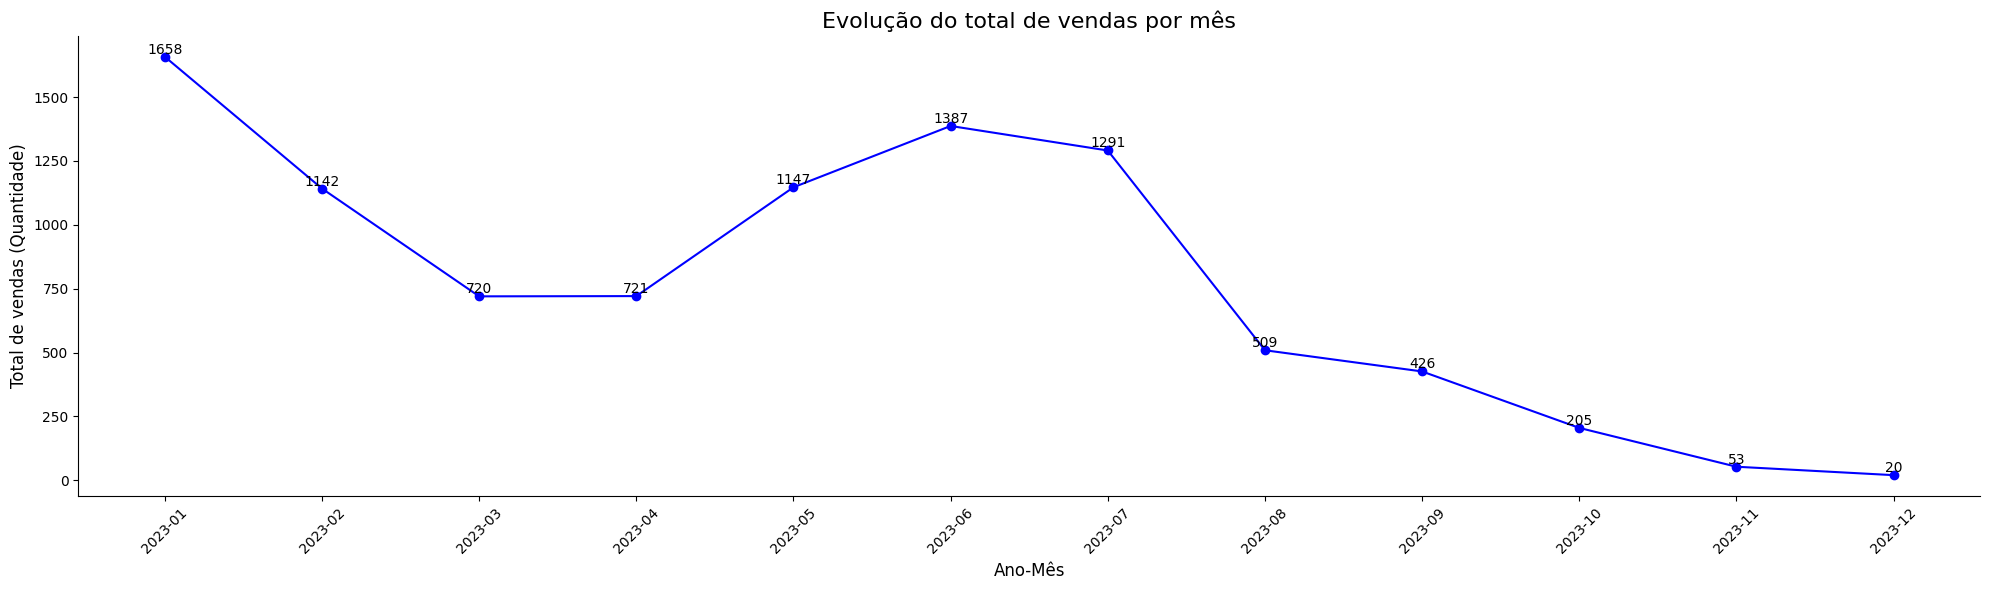

In [13]:
# Converte a coluna 'dt_venda' para o formato de data
dataset['dt_venda'] = pd.to_datetime(dataset['dt_venda'], errors='coerce')

# Cria uma coluna 'mes_ano' no formato MM-YYYY
dataset['mes_ano'] = dataset['dt_venda'].dt.to_period('M').astype(str)

# Agrupa as vendas por mês-ano e soma os valores
dataset_grouped = dataset.groupby('mes_ano', as_index=False)['qt_venda'].sum()

# Plota o gráfico de linha
plt.figure(figsize=(20, 6))
plt.plot(dataset_grouped['mes_ano'], dataset_grouped['qt_venda'], marker='o', linestyle='-', color='b')

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(dataset_grouped['qt_venda']):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Configurações do gráfico
plt.title('Evolução do total de vendas por mês', fontsize=16)
plt.xlabel('Ano-Mês', fontsize=12)
plt.ylabel('Total de vendas (Quantidade)', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Total de vendas por UF**

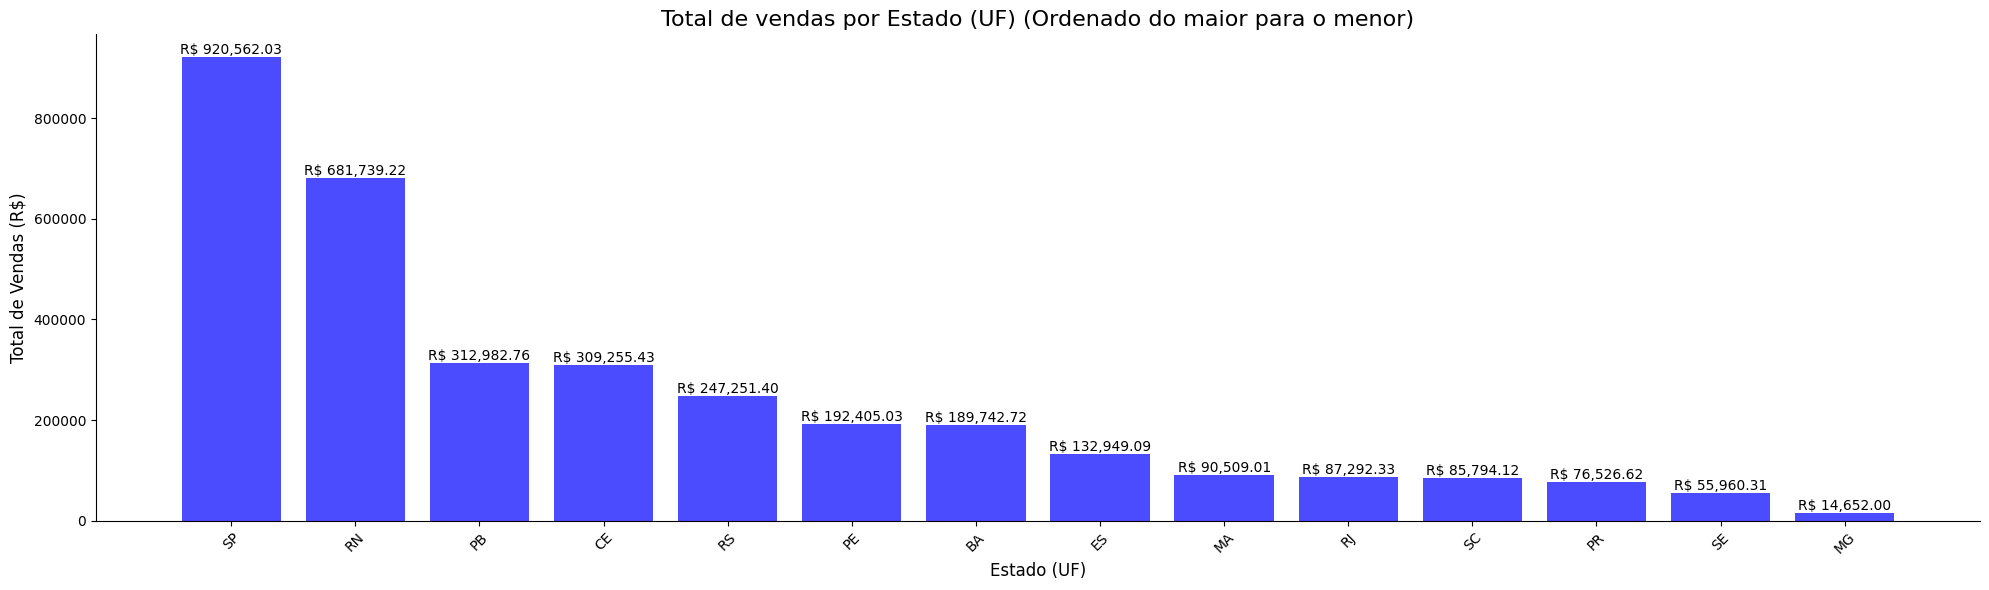

In [14]:
# Converte a coluna 'dt_venda' para o formato de data
dataset['dt_venda'] = pd.to_datetime(dataset['dt_venda'], errors='coerce')

# Agrupa as vendas por Estado (UF) e soma os valores
dataset_grouped = dataset.groupby('uf', as_index=False)['vlr_venda'].sum()

# Ordena os resultados do maior para o menor
dataset_grouped = dataset_grouped.sort_values(by='vlr_venda', ascending=False)

# Plota o gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(dataset_grouped['uf'], dataset_grouped['vlr_venda'], color='b', alpha=0.7)

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(dataset_grouped['vlr_venda']):
    plt.text(i, value, f'R$ {value:,.2f}', ha='center', va='bottom')

# Configurações do gráfico
plt.title('Total de vendas por Estado (UF) (Ordenado do maior para o menor)', fontsize=16)
plt.xlabel('Estado (UF)', fontsize=12)
plt.ylabel('Total de Vendas (R$)', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Total de itens vendidos por UF**

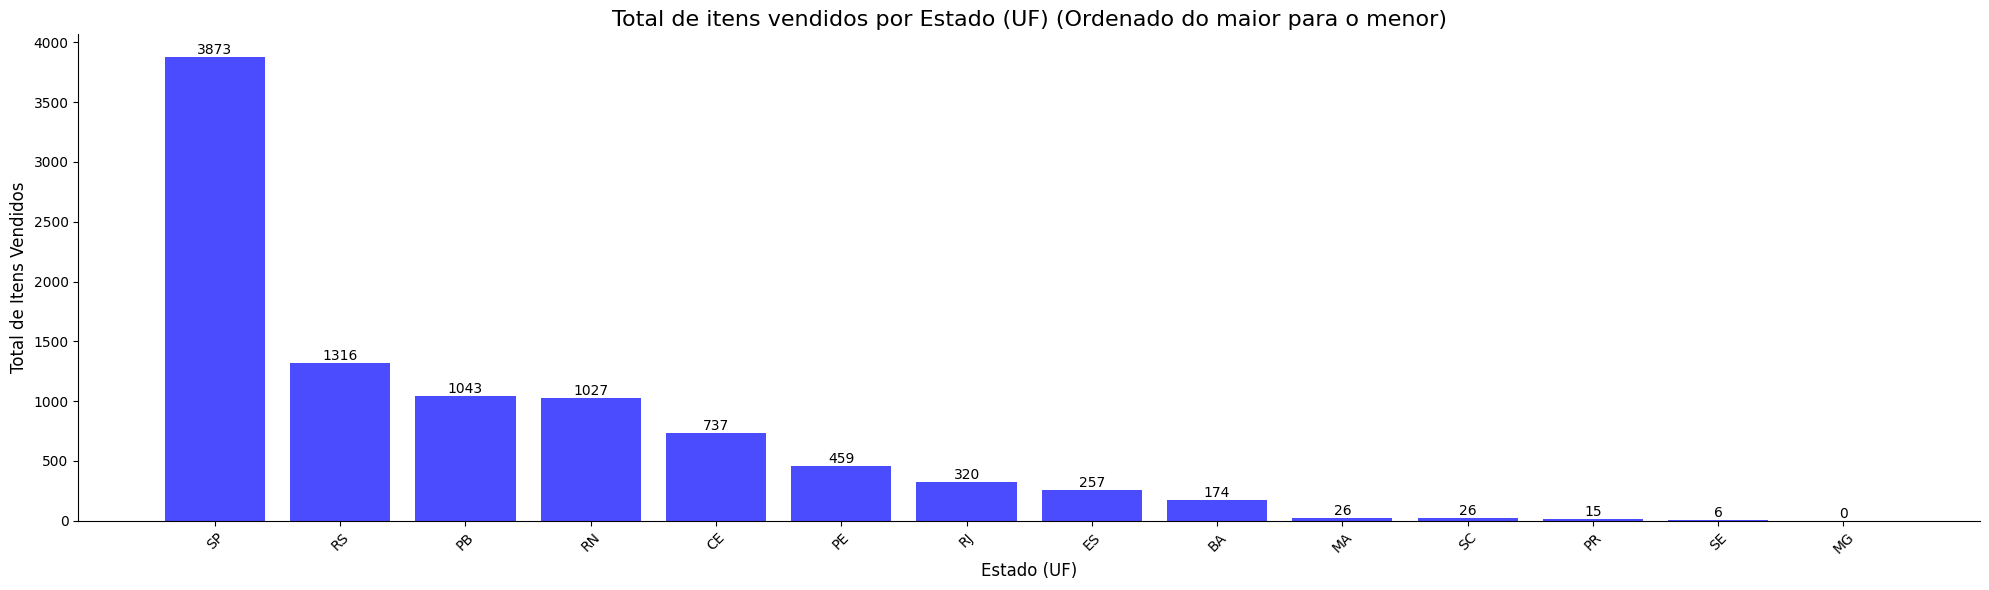

In [15]:
# Converte a coluna 'dt_venda' para o formato de data
dataset['dt_venda'] = pd.to_datetime(dataset['dt_venda'], errors='coerce')

# Agrupa as vendas por Estado (UF) e soma os valores de qt_venda
dataset_grouped = dataset.groupby('uf', as_index=False)['qt_venda'].sum()

# Ordena os resultados do maior para o menor
dataset_grouped = dataset_grouped.sort_values(by='qt_venda', ascending=False)

# Plota o gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(dataset_grouped['uf'], dataset_grouped['qt_venda'], color='b', alpha=0.7)

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(dataset_grouped['qt_venda']):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Configurações do gráfico
plt.title('Total de itens vendidos por Estado (UF) (Ordenado do maior para o menor)', fontsize=16)
plt.xlabel('Estado (UF)', fontsize=12)
plt.ylabel('Total de Itens Vendidos', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Total de vendas por loja**

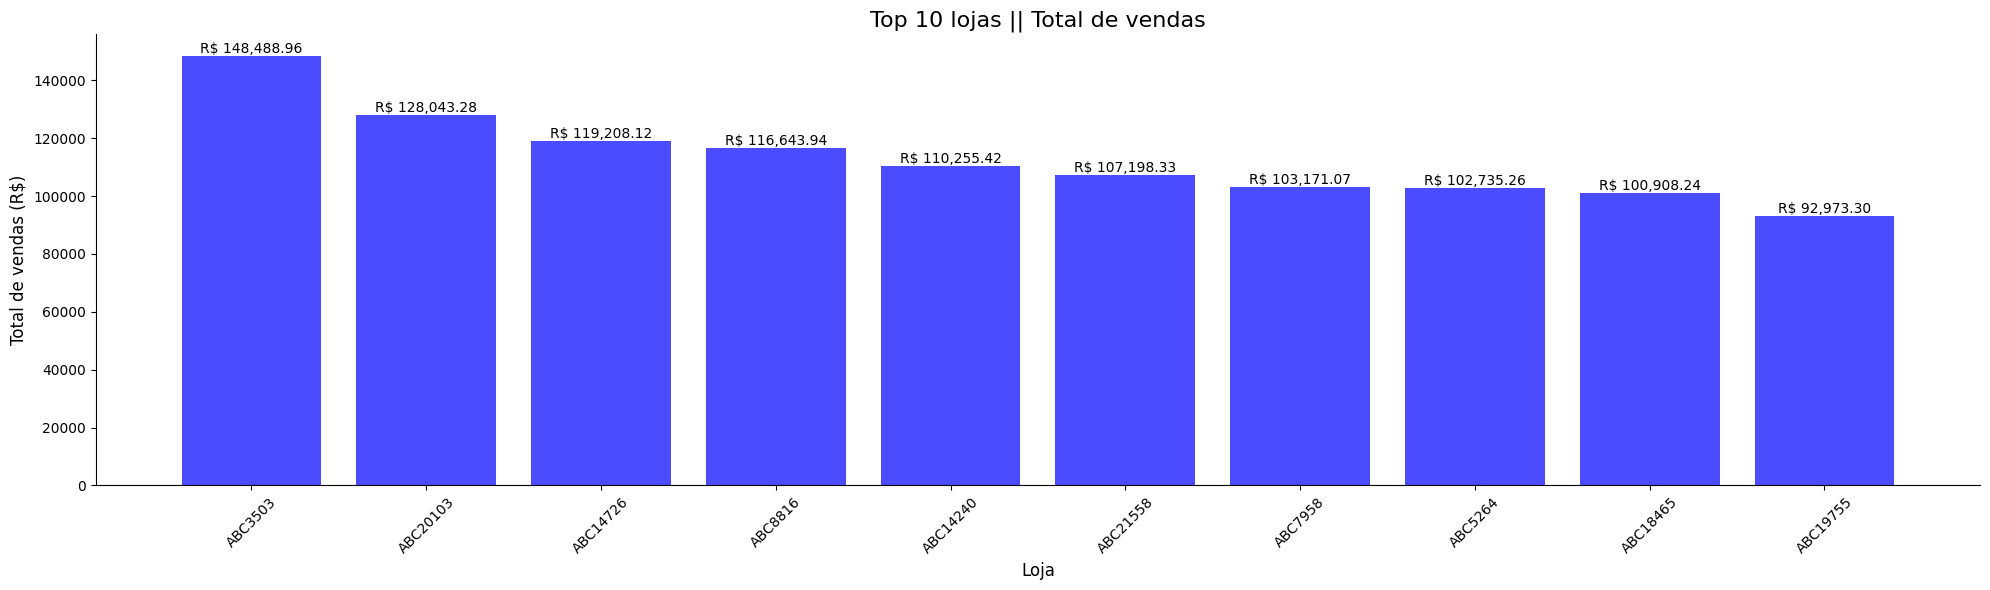

In [16]:
dataset['vlr_venda'] = pd.to_numeric(dataset['vlr_venda'], errors='coerce')

# Agrupa as vendas por Loja e soma os valores
ranking_lojas = dataset.groupby('loja', as_index=False)['vlr_venda'].sum()

# Ordena os resultados do maior para o menor
ranking_lojas = ranking_lojas.sort_values(by='vlr_venda', ascending=False)

# Seleciona o Top 10
top_10_lojas = ranking_lojas.head(10)

# Plota o gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(top_10_lojas['loja'], top_10_lojas['vlr_venda'], color='b', alpha=0.7)

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(top_10_lojas['vlr_venda']):
    plt.text(i, value, f'R$ {value:,.2f}', ha='center', va='bottom')

# Configurações do gráfico
plt.title('Top 10 lojas || Total de vendas', fontsize=16)
plt.xlabel('Loja', fontsize=12)
plt.ylabel('Total de vendas (R$)', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Total de itens vendidos por loja**

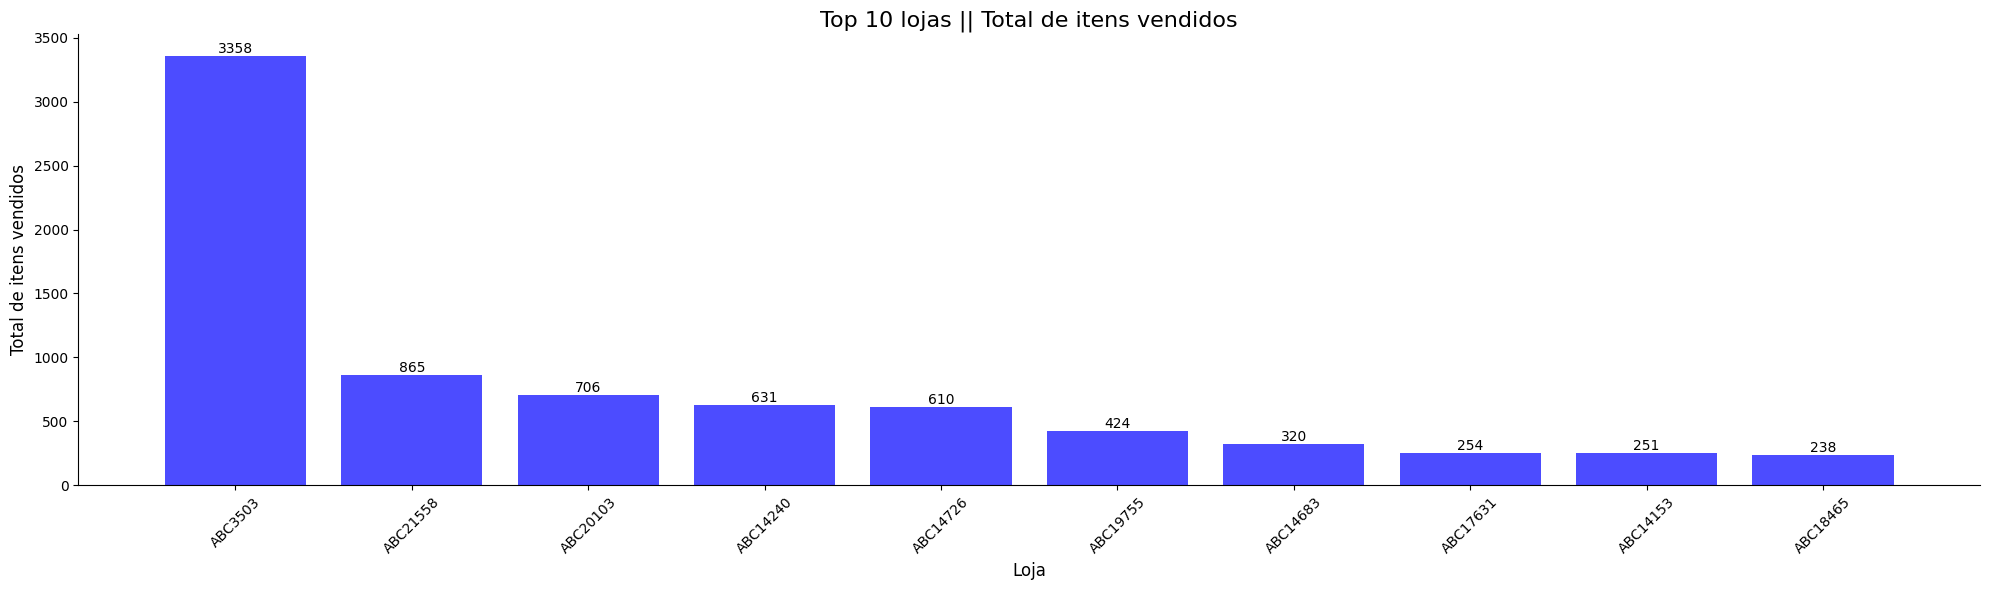

In [17]:
# Agrupa as vendas por Loja e soma os valores de qt_venda
ranking_lojas = dataset.groupby('loja', as_index=False)['qt_venda'].sum()

# Ordena os resultados do maior para o menor
ranking_lojas = ranking_lojas.sort_values(by='qt_venda', ascending=False)

# Seleciona o Top 10
top_10_lojas = ranking_lojas.head(10)

# Plota o gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(top_10_lojas['loja'], top_10_lojas['qt_venda'], color='b', alpha=0.7)

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(top_10_lojas['qt_venda']):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Configurações do gráfico
plt.title('Top 10 lojas || Total de itens vendidos', fontsize=16)
plt.xlabel('Loja', fontsize=12)
plt.ylabel('Total de itens vendidos', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Total de vendas por produto**

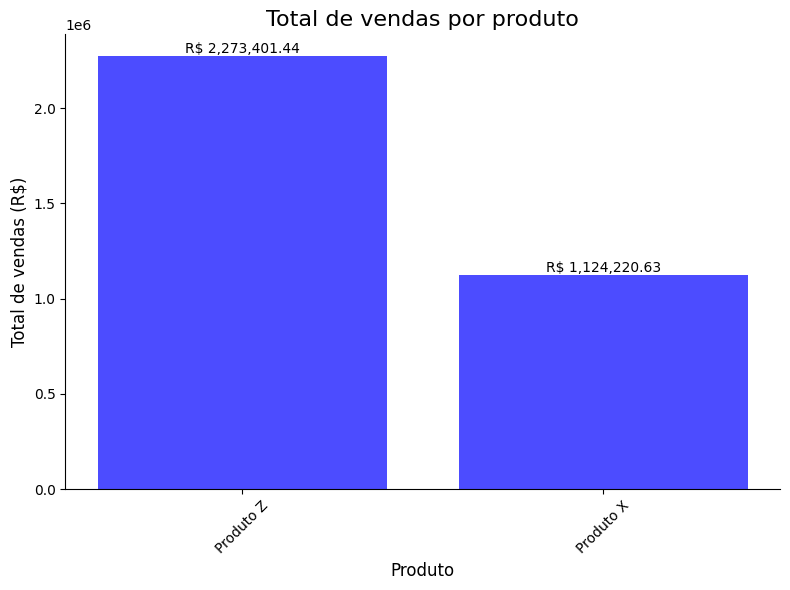

In [18]:
dataset['vlr_venda'] = pd.to_numeric(dataset['vlr_venda'], errors='coerce')

# Agrupa as vendas por Produto e soma os valores
ranking_produtos = dataset.groupby('produto', as_index=False)['vlr_venda'].sum()

# Ordena os resultados do maior para o menor
ranking_produtos = ranking_produtos.sort_values(by='vlr_venda', ascending=False)

# Plota o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(ranking_produtos['produto'], ranking_produtos['vlr_venda'], color='b', alpha=0.7)

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(ranking_produtos['vlr_venda']):
    plt.text(i, value, f'R$ {value:,.2f}', ha='center', va='bottom')

# Configurações do gráfico
plt.title('Total de vendas por produto', fontsize=16)
plt.xlabel('Produto', fontsize=12)
plt.ylabel('Total de vendas (R$)', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Total de itens vendidos por produto**

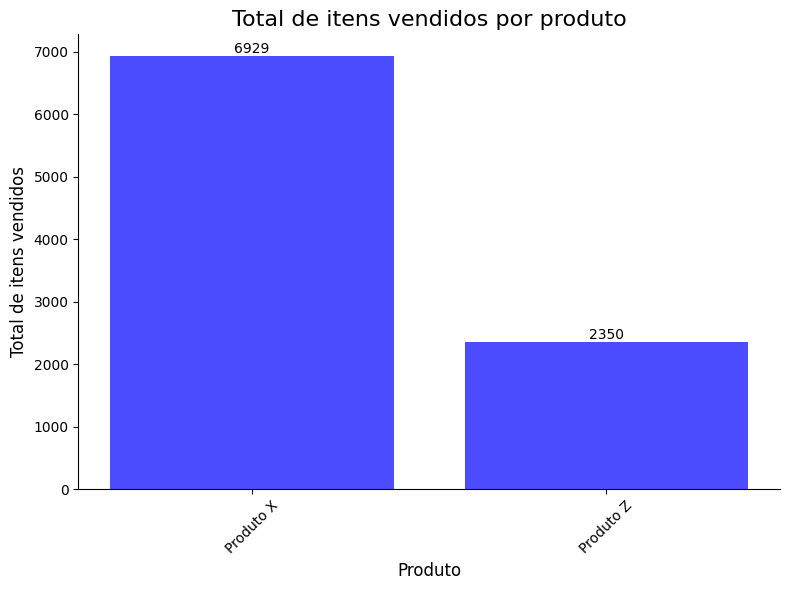

In [19]:
# Converte a coluna 'qt_venda' para o formato numérico, se necessário
dataset['qt_venda'] = pd.to_numeric(dataset['qt_venda'], errors='coerce')

# Agrupa as vendas por Produto e soma os valores de qt_venda
ranking_produtos = dataset.groupby('produto', as_index=False)['qt_venda'].sum()

# Ordena os resultados do maior para o menor
ranking_produtos = ranking_produtos.sort_values(by='qt_venda', ascending=False)

# Plota o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(ranking_produtos['produto'], ranking_produtos['qt_venda'], color='b', alpha=0.7)

# Adiciona rótulos aos pontos do gráfico
for i, value in enumerate(ranking_produtos['qt_venda']):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Configurações do gráfico
plt.title('Total de itens vendidos por produto', fontsize=16)
plt.xlabel('Produto', fontsize=12)
plt.ylabel('Total de itens vendidos', fontsize=12)
plt.grid(False)

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


**Histórico de vendas por produto - Mensal**

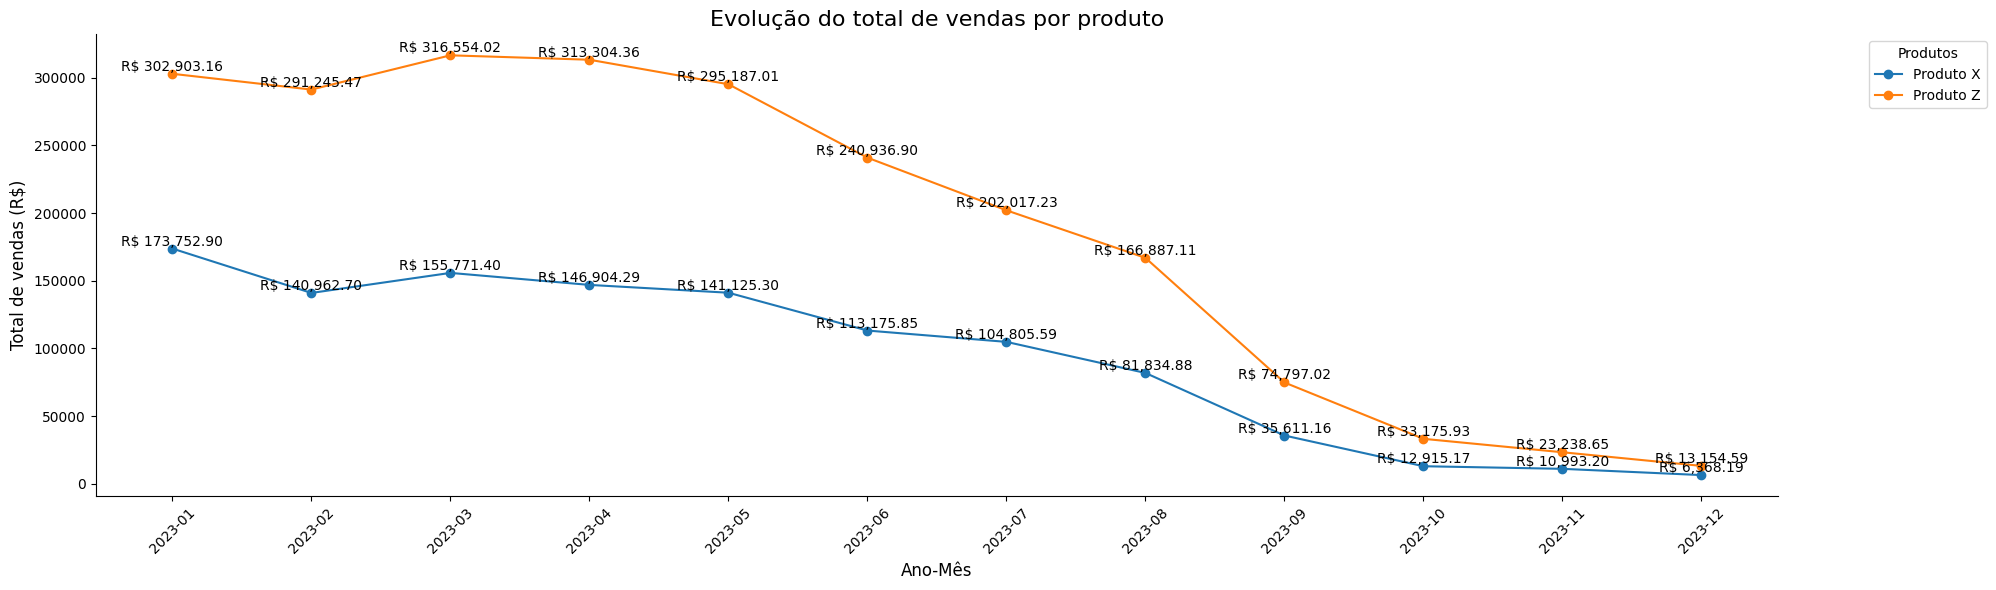

In [20]:
# Converte a coluna 'dt_venda' para o formato de data
dataset['dt_venda'] = pd.to_datetime(dataset['dt_venda'], errors='coerce')

# Cria uma coluna 'mes_ano' no formato MM-YYYY
dataset['mes_ano'] = dataset['dt_venda'].dt.to_period('M').astype(str)

# Agrupa as vendas por mês-ano e produto, somando os valores
dataset_grouped = dataset.groupby(['mes_ano', 'produto'], as_index=False)['vlr_venda'].sum()

# Plota o gráfico de linha para cada produto
plt.figure(figsize=(20, 6))

# Para cada produto, plota a linha correspondente
for product in dataset_grouped['produto'].unique():
    product_data = dataset_grouped[dataset_grouped['produto'] == product]
    plt.plot(product_data['mes_ano'], product_data['vlr_venda'], marker='o', linestyle='-', label=product)

# Adiciona rótulos aos pontos do gráfico
for product in dataset_grouped['produto'].unique():
    product_data = dataset_grouped[dataset_grouped['produto'] == product]
    for i, value in enumerate(product_data['vlr_venda']):
        plt.text(i, value, f'R$ {value:,.2f}', ha='center', va='bottom')

# Configurações do gráfico
plt.title('Evolução do total de vendas por produto', fontsize=16)
plt.xlabel('Ano-Mês', fontsize=12)
plt.ylabel('Total de vendas (R$)', fontsize=12)
plt.grid(False)
plt.legend(title='Produtos', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legenda posicionada ao lado

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()



**Histórico de itens vendidos por produto - Mensal**

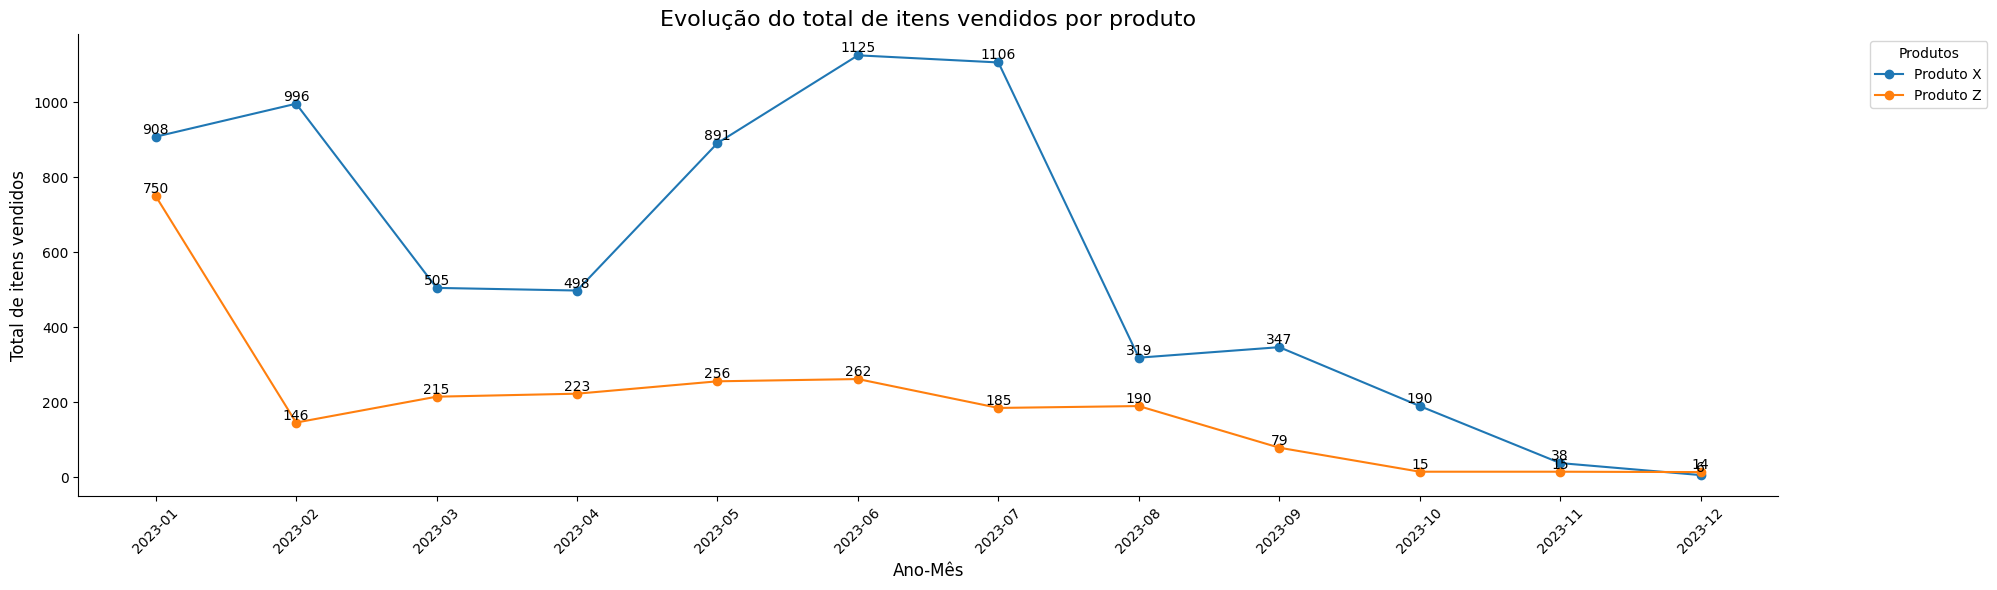

In [21]:
# Converte a coluna 'dt_venda' para o formato de data
dataset['dt_venda'] = pd.to_datetime(dataset['dt_venda'], errors='coerce')

# Cria uma coluna 'mes_ano' no formato MM-YYYY
dataset['mes_ano'] = dataset['dt_venda'].dt.to_period('M').astype(str)

# Agrupa as vendas por mês-ano e produto, somando os valores de qt_venda
dataset_grouped = dataset.groupby(['mes_ano', 'produto'], as_index=False)['qt_venda'].sum()

# Plota o gráfico de linha para cada produto
plt.figure(figsize=(20, 6))

# Para cada produto, plota a linha correspondente
for product in dataset_grouped['produto'].unique():
    product_data = dataset_grouped[dataset_grouped['produto'] == product]
    plt.plot(product_data['mes_ano'], product_data['qt_venda'], marker='o', linestyle='-', label=product)

# Adiciona rótulos aos pontos do gráfico
for product in dataset_grouped['produto'].unique():
    product_data = dataset_grouped[dataset_grouped['produto'] == product]
    for i, value in enumerate(product_data['qt_venda']):
        plt.text(i, value, str(value), ha='center', va='bottom')

# Configurações do gráfico
plt.title('Evolução do total de itens vendidos por produto', fontsize=16)
plt.xlabel('Ano-Mês', fontsize=12)
plt.ylabel('Total de itens vendidos', fontsize=12)
plt.grid(False)
plt.legend(title='Produtos', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legenda posicionada ao lado

# Remove a borda do gráfico
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajusta os rótulos do eixo X para rotacioná-los e melhor visualização
plt.xticks(rotation=45)

# Exibe o gráfico
plt.tight_layout()
plt.show()


### **Passo 4: Resultados**

Nessa última etapa, os resultados obtidos são apresentados por meio de uma ferramenta de Dataviz (Tableau), assim como também as principais perguntas respondidas.

**Utilização de ferramenta de Dataviz**

O uso do Tableau como uma ferramenta para a análise dos dados, permitiu mapear indicadores e responder algumas perguntas baseadas nos dados.

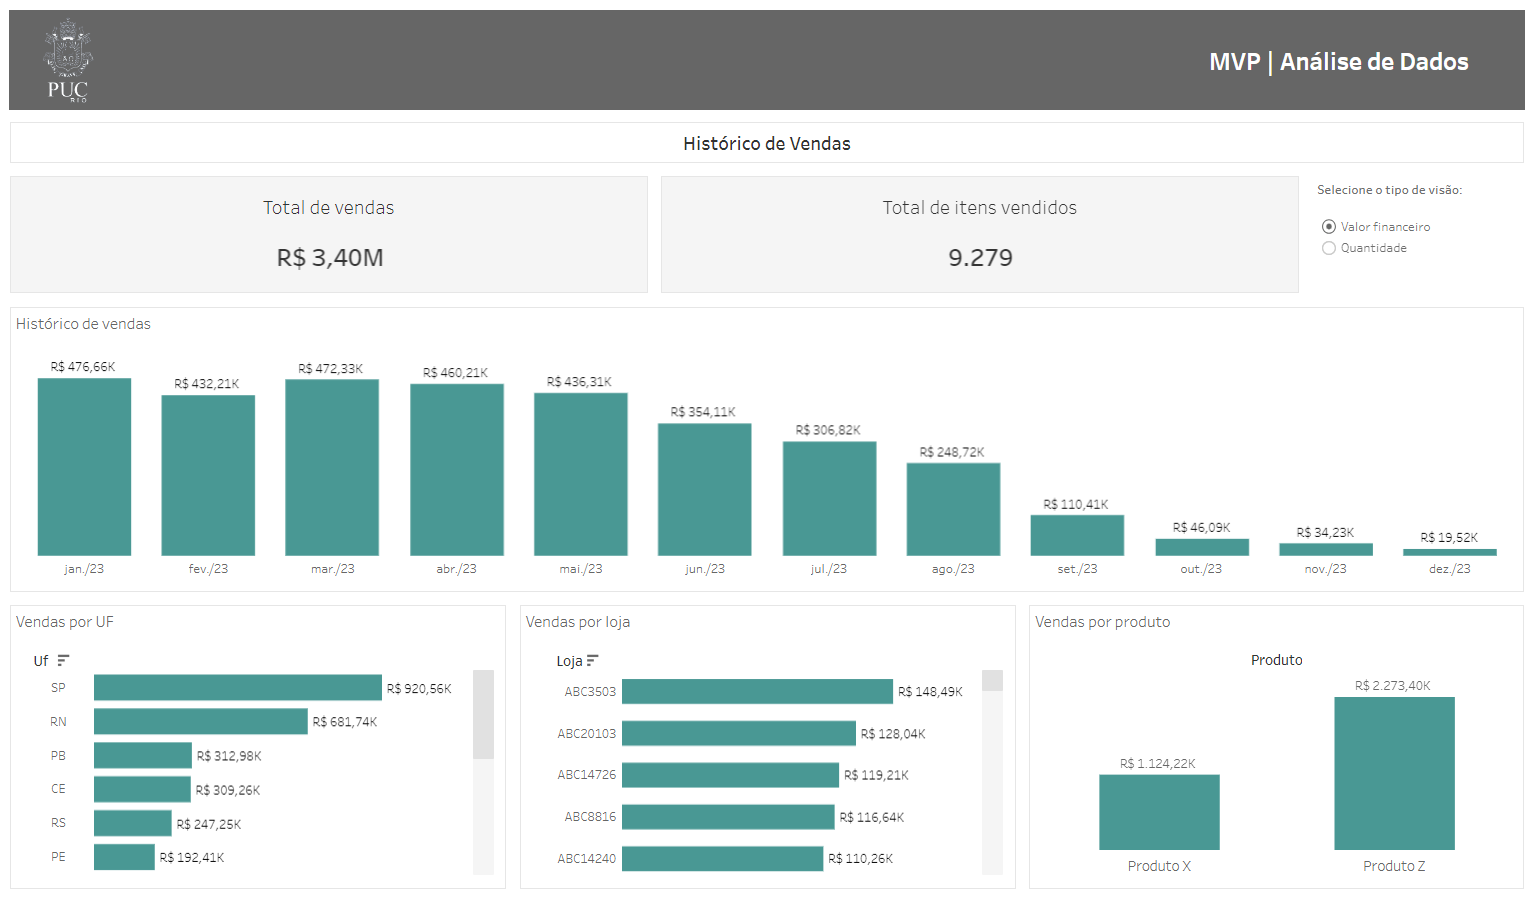

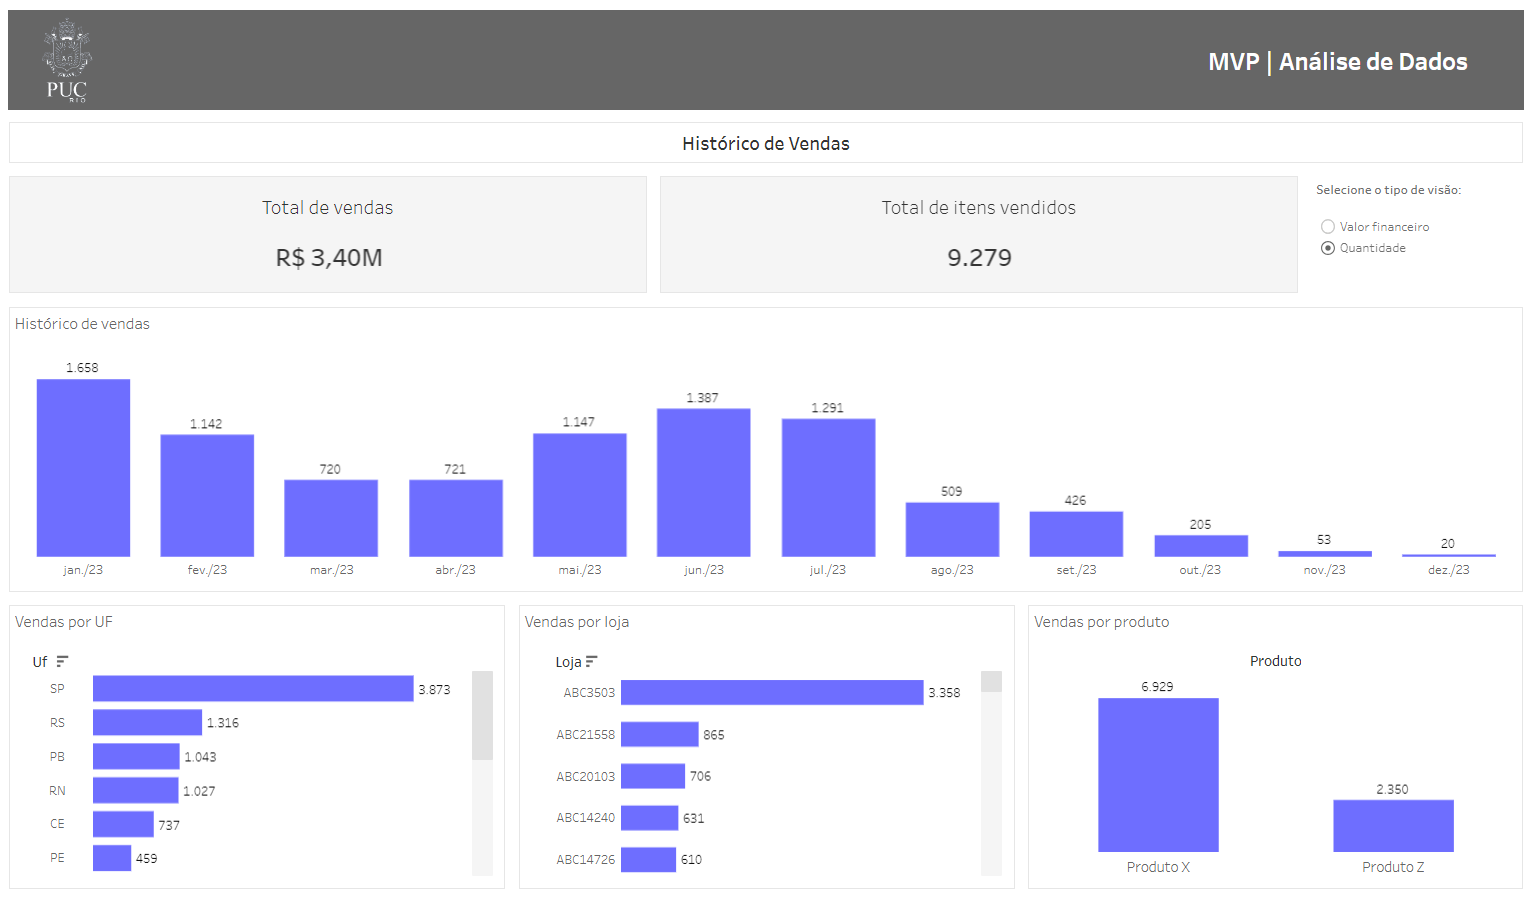

O dashboard acima também está disponível para visualização no servidor do Tableau Public, no link abaixo:

[Histórico de Vendas 2023](https://public.tableau.com/app/profile/joel.dutra6304/viz/HistricodeVendas2023/ControledeVendas)

**Perguntas respondidas:**

Qual o mês em que houve o maior resultado em vendas?

*   *Jan/23 com R$476,66K*


Qual o Estado que mais vendeu durante o ano de 2023?

*   *São Paulo com R$920,56K*


Qual a loja que mais vendeu produtos em 2023?

*   *A loja ABC3503 com R$148,49K*


Qual foi o produto mais vendido (em valor)?

*   *O produto Z vendeu um total de R$2.273,40K*

Qual foi o produto mais vendido (em quantidade)?

*   *O produto X vendeu um total de 6929 unidades*


### **Autoavaliação**

Ao replicar os gráficos históricos por meio do matplot, houve certa dificuldade em definir o período mensal, pois o gráfico retornava a partir de 2023-02 até 2024-01, quando o correto deveria ser entre 2023-01 e 2023-12. Ao tratar o campo de data isoladamente, a visualização retornou corretamente.

### **Considerações finais**

As bibliotecas pandas e matplot são bastante intuitivas. Seu uso foi de fácil entendimento e permitiu trazer vários insights sobre o dataset utilizado, durante o desenvolvimento do MVP.
Acredito que o desenvolvimento do MVP de Machine Learning anteriormente, serviu como base para o manuseio das bibliotecas e possibilitou a exploração das mesmas em outros cenários.